In [1]:
from helpers import generator, ProblemCreator
from collections import defaultdict
import os
import os.path
import pickle 
import dimod
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import os.path
import sympy as sp

In [19]:
font = {
        'size'   : 13}
matplotlib.rc('font', **font)

In [3]:
#N = 59989
def serialize_bqm(N):

    filepath = os.path.join(os.getcwd(), 'problems',f'{dim[0]}_{dim[1]}_{N}.pickle')


    G = generator.Generator(N=N)

    G.get_bqm_from_file()
    G.convert_bqm_to_spin()
    G.serialize_bqm()
    G.save_output_to_file()
    print()
    print(G.bqm)

def generate_Ising(N):
    #for lamda in range(2,15):
    P = ProblemCreator.Problemcreator(N=N)
    P.generate_full_equation()
    print(P.lower_order_expr)
    G = generator.Generator(N = N, bqm = P.return_bqm(), lamda = 1, width = P.get_width(), length = P.get_length())
    G.convert_bqm_to_spin()
    G.serialize_bqm()
    G.save_output_to_file()

def compare_block_sizes():
    N_arr = []
    block_size_arr = []
    binary_arr = []
    quadratic_arr = []

    #for N_i in [N]:
    for N_i in [59989,61937,253009,376289]:
        P = ProblemCreator.Problemcreator(N=N_i)
        N_len = P.get_width() + P.get_length()

        for i in range(1,N_len):

            P = ProblemCreator.Problemcreator(N=N_i, blocksize=i)
            P.generate_full_equation()
            print(i)
            bqm = P.return_bqm()
            print(bqm.num_variables)
            print(bqm.num_interactions)
            print("-----------------")
            N_arr.append(N_i)
            block_size_arr.append(i)
            binary_arr.append(bqm.num_variables)
            quadratic_arr.append(bqm.num_interactions)

    data = {'N': N_arr, 'block_size': block_size_arr,'num_bin': binary_arr, 'num_quadratic': quadratic_arr}
    return pd.DataFrame(data=data)

def create_histograms(N, get_success = False):
    dfs = []
    for N_i in [N]:
        P = ProblemCreator.Problemcreator(N=N_i)
        P.generate_full_equation()
        print(sp.latex(P.lower_order_expr))
        N_len = P.get_width() + P.get_length()
        sr = []
        for i in range(1,N_len):
            P = ProblemCreator.Problemcreator(N=N_i, blocksize=i, lamda=40)
            P.generate_full_equation()
            bqm = P.return_bqm()
            linears = list(bqm.linear.values())
            quadratics = list(bqm.quadratic.values())
            # make linears equal length
            linears += [None]*(len(quadratics)-len(linears))
            if get_success:
                sr.append(P.run_get_success_rates()[1])
            dfs.append(pd.DataFrame({'N':[N]*len(quadratics),'blocksize':[i]*len(quadratics), 'linear_terms': linears, 'quadratic_terms': quadratics}))
        #success_rates[N] = sr
    return dfs

def run_compare_block_sizes():
    df_dict = {'N':[], 'run': [], 'block_size':[], 'smallest_value':[],'success_rate':[]}
    runs = 10
    result_dfs = defaultdict(list)
    for N_i in [8549]:
        #for lamda in np.logspace(1,10,num=5):
        #for lamda in [8]:
        #print("-----------------------")
        #print(f"Lamda {lamda}")
        #P = ProblemCreator.Problemcreator(N=N_i, lamda=lamda)
        N_len = len(bin(N_i))-2
        for block_size in [N_len-2,N_len-1]:#range(1,N_len):
            P = ProblemCreator.Problemcreator(N=N_i, blocksize=block_size,dim=(7,7))
            P.generate_full_equation()
            #continue
            #print(P.check_equation(11,13))
            print(f"Len linears {len(P.bqm.linear)}")
            for run_ in range(runs):        
                smallest_value = None
                run_success_rates = []
                result,success_rate = P.run_get_success_rates()
                result = result.sort_values(by='energy')
                print(success_rate)
                print(result.head(1))
                run_smallest_value = result.head(1).loc[result.head(1).index[0],'energy']
                #if not smallest_value or run_smallest_value < smallest_value:
                #   smallest_value = run_smallest_value
                #run_success_rates.append(success_rate)
                #df_dict['lamda_arr'].append(lamda)
                df_dict['N'].append(N_i)
                df_dict['run'].append(run_)
                df_dict['block_size'].append(block_size)
                df_dict['smallest_value'].append(run_smallest_value)
                df_dict['success_rate'].append(success_rate)
                result_dfs[N_i].append(result)

    return result_dfs, pd.DataFrame(df_dict)


#run_compare_block_sizes()
#result_dfs, result_dict =run_compare_block_sizes()


In [4]:
#esult_dict[['N', 'block_size', 'success_rate']].groupby(['N', 'block_size']).mean()


N = 253009

fig = plt.figure(figsize=(16,8))
ax_energy = fig.gca()
ax_success = ax_energy.twinx()

valid_df = result_dfs[N][0].query('valid==True')
energies_grouped = result_dfs[N][0]['energy', 'num_occurrences'].groupby('energy')



plt.setp(ax_energy.spines.values(), linewidth=3)

ax_energy.plot(result_dfs[N][0]['energy'], result_dfs[N][0]['num_occurrences'])
ax_success.bar(list(valid_df['energy']), list(valid_df['num_occurrences']),width =1e6)
#ax_success.bar([1,1e4,3e10], [5,2,3],width =1e8)


plt.show()
list(valid_df['energy'])
result_dfs[N][0]

In [5]:
all_dfs = []
success_rates =  {}
for N in [59989,61937,253009,376289]:
    all_dfs.append(create_histograms(N, get_success=False))
    print(success_rates)
#all_dfs

260 c_{0} c_{1} - 16 c_{0} c_{2} - 32 c_{0} c_{3} - 64 c_{0} c_{4} - 16 c_{0} p_{0} - 32 c_{0} p_{1} - 64 c_{0} p_{2} + 2 c_{0} p_{3} + 4 c_{0} p_{4} + 8 c_{0} p_{5} - 16 c_{0} q_{0} - 32 c_{0} q_{1} - 64 c_{0} q_{2} + 2 c_{0} q_{3} + 4 c_{0} q_{4} + 8 c_{0} q_{5} - 32 c_{0} t_{0} - 64 c_{0} t_{1} + 2 c_{0} t_{12} + 4 c_{0} t_{13} + 8 c_{0} t_{14} + 4 c_{0} t_{18} + 8 c_{0} t_{19} + 2 c_{0} t_{2} + 8 c_{0} t_{24} + 4 c_{0} t_{3} + 8 c_{0} t_{4} - 64 c_{0} t_{6} + 2 c_{0} t_{7} + 4 c_{0} t_{8} + 8 c_{0} t_{9} + 87 c_{0} - 32 c_{1} c_{2} - 64 c_{1} c_{3} - 128 c_{1} c_{4} - 32 c_{1} p_{0} - 64 c_{1} p_{1} - 128 c_{1} p_{2} + 4 c_{1} p_{3} + 8 c_{1} p_{4} + 16 c_{1} p_{5} - 32 c_{1} q_{0} - 64 c_{1} q_{1} - 128 c_{1} q_{2} + 4 c_{1} q_{3} + 8 c_{1} q_{4} + 16 c_{1} q_{5} - 64 c_{1} t_{0} - 128 c_{1} t_{1} + 4 c_{1} t_{12} + 8 c_{1} t_{13} + 16 c_{1} t_{14} + 8 c_{1} t_{18} + 16 c_{1} t_{19} + 4 c_{1} t_{2} + 16 c_{1} t_{24} + 8 c_{1} t_{3} + 16 c_{1} t_{4} - 128 c_{1} t_{6} + 4 c_{1} t_{7

In [6]:
all_dfs[0]

[         N  blocksize  linear_terms  quadratic_terms
 0    59989          1          -1.0             16.0
 1    59989          1          -3.0              2.0
 2    59989          1          -2.0              2.0
 3    59989          1          -2.0           1203.0
 4    59989          1          -2.0           1759.0
 ..     ...        ...           ...              ...
 630  59989          1           NaN            -16.0
 631  59989          1           NaN              2.0
 632  59989          1           NaN              2.0
 633  59989          1           NaN              2.0
 634  59989          1           NaN              2.0
 
 [635 rows x 4 columns],
          N  blocksize  linear_terms  quadratic_terms
 0    59989          2          -1.0              2.0
 1    59989          2          -5.0              2.0
 2    59989          2          -5.0           7446.0
 3    59989          2          -5.0           6956.0
 4    59989          2          -5.0           5452.0
 

In [7]:
#n_bins = 20
#for df in dfs:
 #   fig, axs = plt.subplots(1, 2, tight_layout=True)
  #  axs[0].hist(df[df['linear_terms']< 100]['linear_terms'], bins=n_bins)
   # axs[0].set_title('linear')
   # axs[1].hist(df['quadratic_terms'], bins=n_bins)
   # axs[1].set_title('quadratic')

    #fig.suptitle(f"Histogram for N={df.head(1).loc[0,'N']} and blocksize={df.head(1).loc[0,'blocksize']}")


y_lims = {
    'linear_terms': (0,200),
    'quadratic_terms': (-200,600)
}

for term in ['linear_terms', 'quadratic_terms']:
    fig, axes = plt.subplots(nrows=3, ncols=len(dfs[0:5]), figsize=(15, 15))
    count = 0
    for row in range(3):
        for column in range(5):
            df = dfs[count]
            df.boxplot(column=[term], ax=axes[row][column], showfliers=True)
            axes[row][column].set_title(f"blocksize={df.head(1).loc[0,'blocksize']}")
            #axes[row][column].set_ylim(y_lims[term])
            count+=1
    # Adjust layout to prevent overlap

    plt.suptitle(f"Variable range for {term} for N = {df.head(1).loc[0,'N']} ")
    plt.tight_layout()
    plt.show()

In [34]:


overview_dfs = {}
for dfs in all_dfs:
    range_ = []
    linears = []
    quadratic = []
    for df in dfs:
        print("------------------")
        print(f"Range {abs(df['linear_terms'].max()-df['linear_terms'].min())}")
        range_.append(max(df['linear_terms'].max(),abs(df['linear_terms'].min())))    #-df['linear_terms'].min()))
        print(f"Num linears: {df['linear_terms'].count()}")
        linears.append(df['linear_terms'].count())
        print(f"Num quadratic: {df['quadratic_terms'].count()}")
        quadratic.append(df['quadratic_terms'].count())
        N = df.head(1).loc[0,'N']
        print(df)
    overview_dfs[N] = pd.DataFrame({'range': range_, 'linears': linears, 'quadratic': quadratic})
print(overview_dfs)


------------------
Range 5523.0
Num linears: 80
Num quadratic: 635
         N  blocksize  linear_terms  quadratic_terms
0    59989          1          -1.0             16.0
1    59989          1          -3.0              2.0
2    59989          1          -2.0              2.0
3    59989          1          -2.0           1203.0
4    59989          1          -2.0           1759.0
..     ...        ...           ...              ...
630  59989          1           NaN            -16.0
631  59989          1           NaN              2.0
632  59989          1           NaN              2.0
633  59989          1           NaN              2.0
634  59989          1           NaN              2.0

[635 rows x 4 columns]
------------------
Range 22325.0
Num linears: 65
Num quadratic: 701
         N  blocksize  linear_terms  quadratic_terms
0    59989          2          -1.0              2.0
1    59989          2          -5.0              2.0
2    59989          2          -5.0           

In [12]:
max(3,2)

3

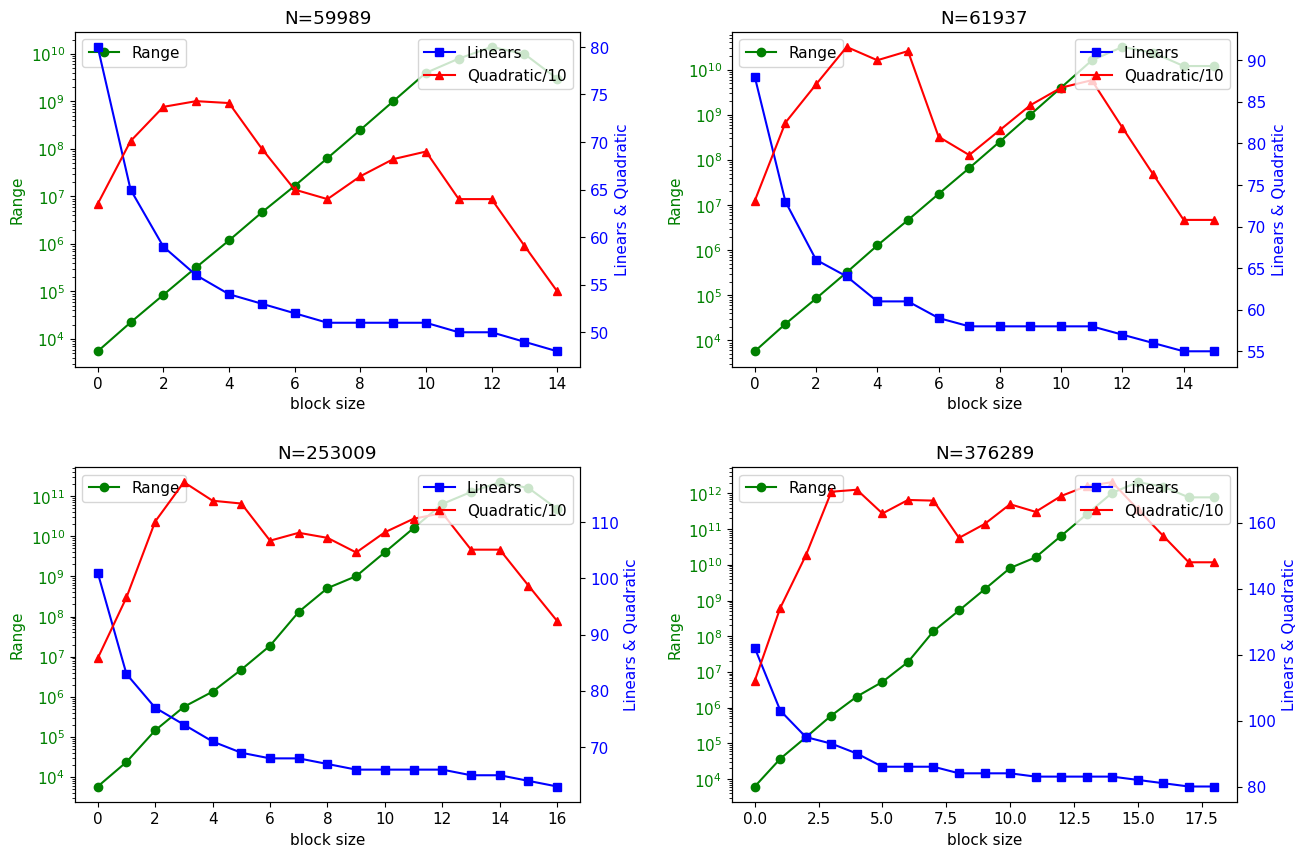

In [9]:
# Plotting

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten() 


for i, (N, overview_df) in enumerate(overview_dfs.items()):
    ax1 = axs[i]

    # Plotting the 'range' data with logarithmic scale on the left y-axis
    ax1.plot(overview_df.index, overview_df['range'], 'g-', label='Range', marker='o')
    ax1.set_xlabel('block size')
    ax1.set_ylabel('Range', color='g')
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='g')

    # Creating a second y-axis for the 'linears' and 'quadratic' data
    ax2 = ax1.twinx()
    ax2.plot(overview_df.index, overview_df['linears'], 'b-', label='Linears', marker='s')
    ax2.plot(overview_df.index, overview_df['quadratic']/10, 'r-', label='Quadratic/10', marker='^')
    ax2.set_ylabel('Linears & Quadratic', color='b')
    ax2.tick_params(axis='y', labelcolor='b')


    # Adding legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    ax1.set_title(f'N={N}')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig("figures/range_term_analysis.svg")
plt.show()


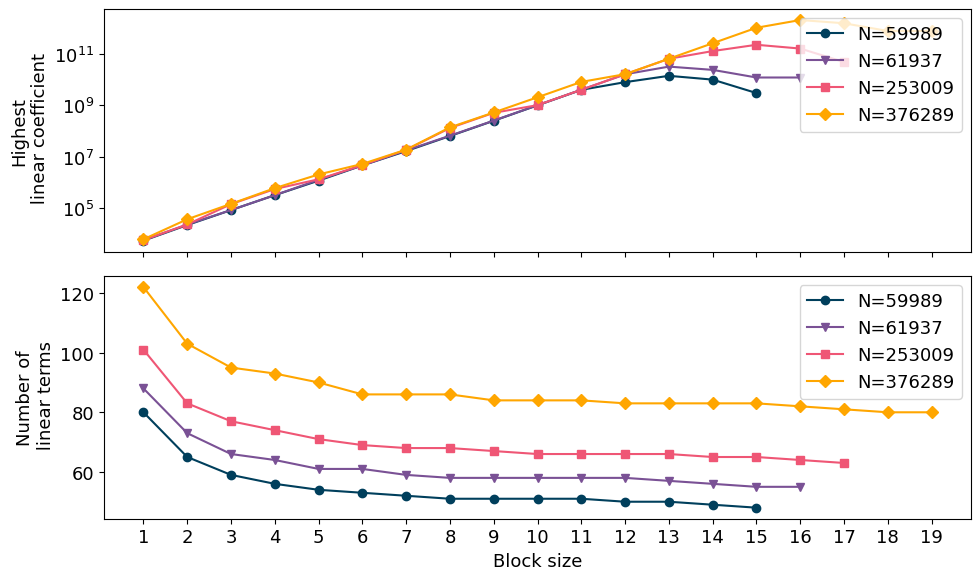

In [30]:
colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
markers = ['o','v','s', 'D']
linears = {}
quadratic = {}
range_ = {}
for N,overview_df in overview_dfs.items():
    linears[N] = overview_df[['linears']]
    quadratic[N] = overview_df[['quadratic']]
    range_[N] = overview_df[['range']]

column_names = [ 'Highest\n linear coefficient','Number of\n linear terms']
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)


axs = axs.flatten()  # easier indexing
columns = [range_,linears]
# Plot each DataFrame's columns in separate subplots
for i,d_dict in enumerate(columns):
    ax = axs[i]
    for j, (N, values) in enumerate(d_dict.items()):
        ax.plot(values.index, values, marker=markers[j], label=f'N={N}', color=colors[j])
    
    # Apply appropriate scaling
    if i== 0:
        ax.set_yscale('log')    
    
    # Update x-axis labels to represent blocksize
    ax.set_xticks(overview_df.index)
    ax.set_xticklabels(overview_df.index + 1)
    
    # Set title for each subplot
    ax.set_ylabel(column_names[i])
    
    # Add legend
    ax.legend(loc='upper right')

axs[1].set_xlabel('Block size')


# Adjust layout to prevent overlap and add spacing
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout()
plt.savefig('figures/range_term_analysis3f.svg', bbox_inches='tight')
# Show the plot
plt.show()

In [ ]:
with open(os.path.join(os.getcwd(), 'FZJtemp', 'result253009.pickle'),'rb') as f:
    df = pd.read_pickle(f)
df

,N,run,block_size,smallest_value,success_rate
0,253009,0,1,24.0,0.1
1,253009,1,1,12.0,0.0
2,253009,2,1,33.0,0.0
3,253009,3,1,34.0,0.0
4,253009,4,1,17.0,0.1
...,...,...,...,...,...
165,253009,5,17,12688804.0,0.0
166,253009,6,17,26433536.0,0.5
167,253009,7,17,14830480.0,0.0
168,253009,8,17,22624512.0,0.2


In [ ]:
dfs[0]['quadratic_terms'].count()

632

In [ ]:
dfs[0]

,N,blocksize,linear_terms,quadratic_terms
0,59989,1,-1.0,16.0
1,59989,1,-3.0,2.0
2,59989,1,-2.0,2.0
3,59989,1,-2.0,25.0
4,59989,1,-2.0,21.0
...,...,...,...,...
627,59989,1,NaN,-16.0
628,59989,1,NaN,2.0
629,59989,1,NaN,-16.0
630,59989,1,NaN,-16.0
